<a href="https://colab.research.google.com/github/Tonnykipkosgei/Programmable_hardware/blob/main/Das.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install gdown
!gdown --folder 127mX4nDfRrY6lHdfD4BNdfG9Bpi1fdXw



Retrieving folder contents
Processing file 1TQSmNS5pxzFo9dKt9mtccIZcxVto8MhL data_UTC_20241029_170330.268.tdms
Processing file 1fJmqLuIgI52RGh4juQWqfIqvT4Kp9ZmP data_UTC_20241029_170452.876.tdms
Processing file 1ahSnwJvJdqSYdX7WvHX30s9ErA4Ek6M_ data_UTC_20241029_170517.269.tdms
Processing file 1LYM9sykD_mm7vcV3pCf3on9wxWath9un data_UTC_20241029_170600.513.tdms
Processing file 1F4b5uUbL5VVy_g-V8VFJbTgPYJCBltCZ data_UTC_20241029_170642.601.tdms
Processing file 11jkUEenGfPCfB2CRhDDJVx9HmFZqGdCh data_UTC_20241029_170708.803.tdms
Processing file 1ipXWhvsFpmBA4TgMo4O_BH9NV07hsHs8 data_UTC_20241029_170734.860.tdms
Processing file 1WIZuZ1KRe2MxkFkGfETKJhZdPsZaX7w6 data_UTC_20241029_170918.176.tdms
Processing file 162cGXuCyBsPs2p4OaI2Dt4o6nZs5Iz5K data_UTC_20241029_171010.233.tdms
Processing file 1NTpRQHha4W7n7jiYmbmY8tqzWwd6LsWo data_UTC_20241029_171053.546.tdms
Processing file 1e-3VHHXvd9sYomzlkOe1pehdSbVKsp9L tests20241029.txt
Retrieving folder contents completed
Building directory structure

In [21]:
# Path to your TDMS file
tdms_file_path = 'data_UTC_20241029_170330.268.tdms'

# Use the TDMS reader
import TDMS_Reader as tdms

tdms_file_path='/content/20241029/data_UTC_20241029_171053.546.tdms'

with tdms.TdmsReader(tdms_file_path) as reader:
    #print("File info:", reader.fileinfo)
    print("File properties:", reader.get_properties())
    print("File properties:", reader.get_data())

    file_info = reader.get_properties()

    print("File Tag:", reader.fileinfo['file_tag'])
    print("TDMS Version:", reader.fileinfo['version'])
    print("Sampling frequency", file_info['SamplingFrequency[Hz]'])
    print("Gauge Length", file_info['GaugeLength'])



File properties: {'name': 'data_UTC_20241029_171053.546', 'SamplingFrequency[Hz]': 2500.0, 'SpatialResolution[m]': 1.0, 'Fibre Type': 'Standard', 'Zone Type': 'Single-Zone', 'Start Distance (m)': -212.8685720371884, 'Stop Distance (m)': 8019.070499117967, 'StreamTime[s]': inf, 'Continuous Mode': True, 'StartPosition[m]': 1.0, 'MeasureLength[m]': 8064, 'Zone Setup': False, 'Precise Sampling Frequency (Hz)': 10000.0, 'Zones': '', 'Power Decrement': 0.0, 'Source Mode': 'Normal', 'Time Decimation': 4, 'OutputDecimation[bool]': 4, 'P': 7, 'P Coefficients': '1.000000;1.000000;1.000000;1.000000;1.000000;1.000000;1.000000\r\n', 'Integration Cut Off (Hz)': 3.14, 'Normalization': True, 'Decimation Filter': True, 'Acoustic Output': 'Differential', 'Diagnostic Output': 'R, S, As & dP', 'Window': 0, 'Physical Fibre Length (m)': 8000.0, 'PeakVoltage[V]': 2.0, 'Pulse 2 Delay (ns)': 500.0, 'PulseWidth[ns]': 120.0, 'OffsetLength': 64.0, 'Reference length': 3, 'SavingBandwidth (MB/s)': 350.0, 'Reference

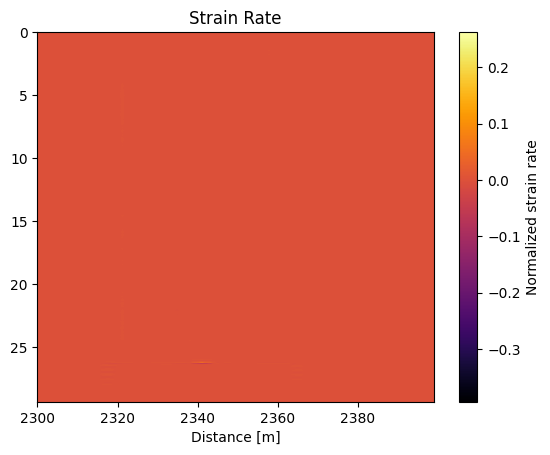

Text(0, 0.5, 'Frequency [Hz]')

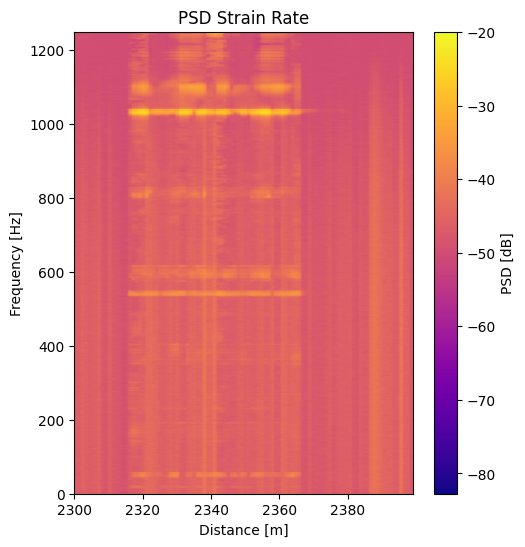

In [24]:
import numpy as np
import pandas as pd
import TDMS_Reader as tdms
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft


with tdms.TdmsReader(tdms_file_path) as reader:

    dat = reader.get_data()
    f = reader.get_properties()
    # Extract necessary parameters from fileinfo
    SF = file_info['SamplingFrequency[Hz]']  # Sampling frequency [Hz], assumes 0-based indexing
    GL = file_info['GaugeLength']  # Gauge length [m], assumes 0-based indexing

def convertint(data, fileinfo):
    """
    Converts the integer data from the Silixa DAS file to strain rate values.

    Parameters:
    - data (numpy.ndarray or pandas.Series): The raw integer data from the Silixa DAS file.
    - fileinfo (pandas.DataFrame): Metadata containing the sampling frequency and gauge length.

    Returns:
    - numpy.ndarray or pandas.Series: Converted strain rate values.
    """


    # Apply the conversion formula
    data = data * 2e-13 * 116 * SF / GL  # 2e-13 rad/int, 116 nm/rad

    return data

converted_data=convertint(dat,f)


# Normalize the data
norm_data = (converted_data - np.min(converted_data)) / (np.max(converted_data) - np.min(converted_data))

# Select a specific range for `x`
x = np.arange(2300, 2400)  # Replace with the desired range
norm_data = norm_data[:, x]

# Remove the mean
norm_data -= np.mean(norm_data)

# Generate the time array
t = np.arange(0,dat.shape[0]) / SF

# Plot the strain rate
plt.figure()
plt.imshow(norm_data, aspect='auto', extent=[x[0], x[-1], t[-1], t[0]], cmap='inferno')
plt.colorbar(label='Normalized strain rate')
plt.xlabel("Distance [m]")
#plt.ylabel("Time [s]")
plt.title("Strain Rate")
plt.show()

# Frequency Analysis
# FFT in time
L = norm_data.shape[0]  # Number of time samples
f = np.linspace(0, SF/2, L//2 + 1)  # Frequency axis
Y = fft(norm_data, axis=0)  # FFT along the time axis
P2 = np.abs(Y / L)  # Two-sided spectrum
P1 = P2[:L//2 + 1, :]  # Single-sided spectrum
P1[1:-1, :] *= 2  # Account for symmetry

# Plotting the Power Spectral Density (PSD)
plt.figure(figsize=(12, 6))
# Full PSD
plt.subplot(1, 2, 1)
plt.imshow(10 * np.log10(P1), aspect='auto', extent=[x[0], x[-1], f[0], f[-1]], cmap='plasma')
plt.colorbar(label="PSD [dB]")
plt.title("PSD Strain Rate")
plt.xlabel("Distance [m]")
plt.ylabel("Frequency [Hz]")




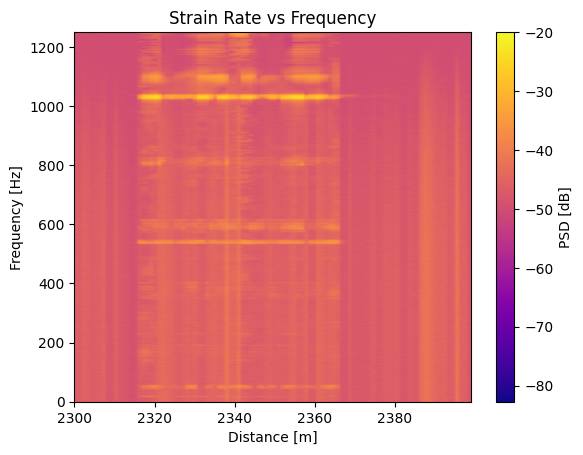

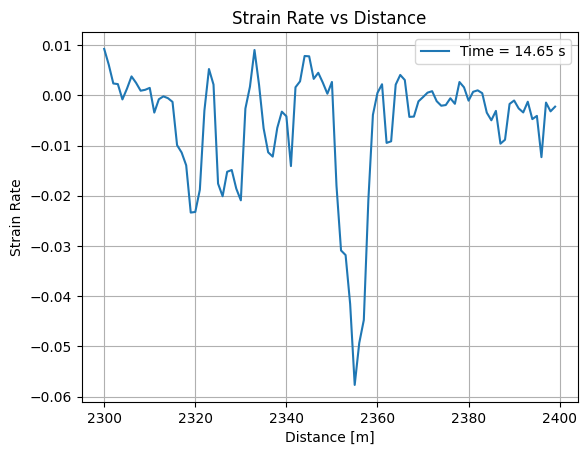

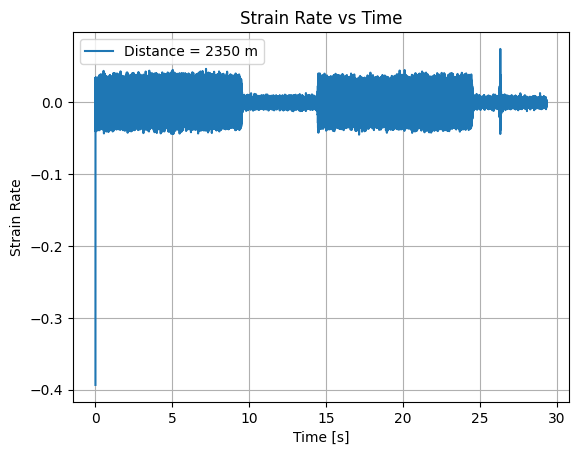

In [25]:
import numpy as np
import pandas as pd
import TDMS_Reader as tdms
import matplotlib.pyplot as plt
from scipy.fft import fft

# TDMS file reading and data preparation
with tdms.TdmsReader(tdms_file_path) as reader:
    dat = reader.get_data()
    f = reader.get_properties()

    # Extract necessary parameters from fileinfo
    SF = f['SamplingFrequency[Hz]']  # Sampling frequency [Hz]
    GL = f['GaugeLength']  # Gauge length [m]

def convertint(data, fileinfo):
    """
    Converts the integer data from the Silixa DAS file to strain rate values.

    Parameters:
    - data (numpy.ndarray or pandas.Series): The raw integer data from the Silixa DAS file.
    - fileinfo (pandas.DataFrame): Metadata containing the sampling frequency and gauge length.

    Returns:
    - numpy.ndarray or pandas.Series: Converted strain rate values.
    """
    return data * 2e-13 * 116 * SF / GL  # Conversion formula

# Step 1: Convert data
converted_data = convertint(dat, f)

# Step 2: Normalize data
norm_data = (converted_data - np.min(converted_data)) / (np.max(converted_data) - np.min(converted_data))

# Step 3: Time and distance selection
x = np.arange(2300, 2400)  # Distance range
norm_data = norm_data[:, x]
norm_data -= np.mean(norm_data)  # Remove the mean
t = np.arange(0, dat.shape[0]) / SF  # Time array

# Step 4: Frequency Analysis using FFT
L = norm_data.shape[0]
frequencies = np.linspace(0, SF / 2, L // 2 + 1)
Y = fft(norm_data, axis=0)
P2 = np.abs(Y / L)
P1 = P2[:L // 2 + 1, :]
P1[1:-1, :] *= 2

# Plot 1: Strain Rate vs Frequency
plt.figure()
plt.imshow(10 * np.log10(P1), aspect='auto', extent=[x[0], x[-1], frequencies[0], frequencies[-1]], cmap='plasma')
plt.colorbar(label="PSD [dB]")
plt.title("Strain Rate vs Frequency")
plt.xlabel("Distance [m]")
plt.ylabel("Frequency [Hz]")
plt.show()

# Plot 2: Strain Rate vs Distance (at a fixed time index, e.g., midpoint)
time_index = norm_data.shape[0] // 2  # Example: midpoint of the time series
strain_rate_distance = norm_data[time_index, :]  # Data for this time index
plt.figure()
plt.plot(x, strain_rate_distance, label=f"Time = {t[time_index]:.2f} s")
plt.title("Strain Rate vs Distance")
plt.xlabel("Distance [m]")
plt.ylabel("Strain Rate")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Strain Rate vs Time (at a fixed distance index, e.g., midpoint)
distance_index = len(x) // 2  # Example: midpoint of the distance series
strain_rate_time = norm_data[:, distance_index]  # Data for this distance index
plt.figure()
plt.plot(t, strain_rate_time, label=f"Distance = {x[distance_index]} m")
plt.title("Strain Rate vs Time")
plt.xlabel("Time [s]")
plt.ylabel("Strain Rate")
plt.legend()
plt.grid()
plt.show()
